In [120]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [121]:
import numpy as np
import pandas as pd

In [122]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [123]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [124]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [125]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [126]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [127]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [128]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

In [129]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [130]:
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [131]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [171]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column



all_data = pd.read_sql("SELECT date, prcp AS 'precipitation' \
FROM Measurement WHERE date >= '2016-08-23'", conn)
all_data.tail(10)

,date,precipitation
2220,2017-08-14,0.22
2221,2017-08-15,0.42
2222,2017-08-16,0.42
2223,2017-08-17,0.13
2224,2017-08-18,NaN
2225,2017-08-19,0.09
2226,2017-08-20,NaN
2227,2017-08-21,0.56
2228,2017-08-22,0.50
2229,2017-08-23,0.45


In [175]:
new_index = all_data.set_index("date")
new_index.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


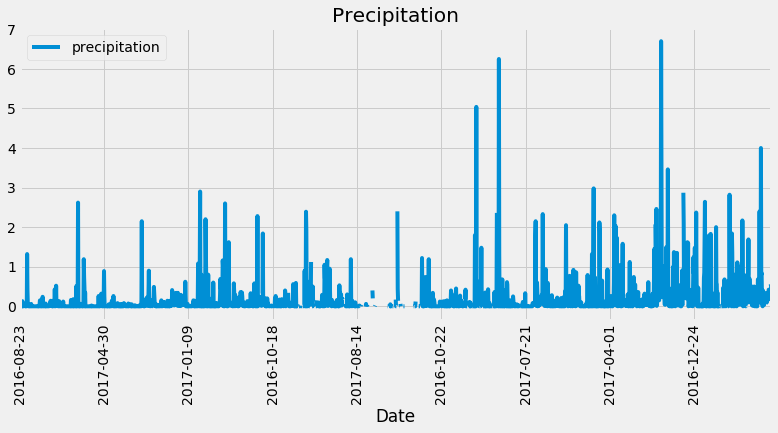

In [201]:
# Use Pandas Plotting with Matplotlib to plot the data
new_index.plot()
plt.title("Precipitation")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.rcParams["figure.figsize"]=[12,5]
plt.savefig("Precipitation.png",bbox_inches = 'tight')

In [136]:
# Use Pandas to calcualte the summary statistics for the precipitation data
all_data.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [137]:
# Design a query to show how many stations are available in this dataset?
stations_first = session.query(Stations).first()
stations_first

In [138]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(Stations.station).count()
total_stations


9

In [139]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = session.query(Measurements.station,func.count(Measurements.station))\
.group_by(Measurements.station).order_by(func.count(Measurements.station).desc()).all()
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [166]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

max_temp = pd.read_sql("SELECT MAX(tobs)\
FROM Measurement \
WHERE station = 'USC00519281'", conn)
max_temp


,MAX(tobs)
0,85.0


In [167]:
min_temp = pd.read_sql("SELECT MIN(tobs)\
FROM Measurement \
WHERE station = 'USC00519281'", conn)
min_temp

,MIN(tobs)
0,54.0


In [169]:
avg_temp = pd.read_sql("SELECT AVG(tobs)\
FROM Measurement \
WHERE station = 'USC00519281'", conn)
avg_temp

,AVG(tobs)
0,71.663781


In [181]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_station = pd.read_sql("SELECT date,tobs  \
FROM Measurement \
WHERE station = 'USC00519281' AND date >= '2016-08-23'", conn)
highest_station.head()

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


In [183]:
highest = highest_station.set_index("date")
highest.head()

,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


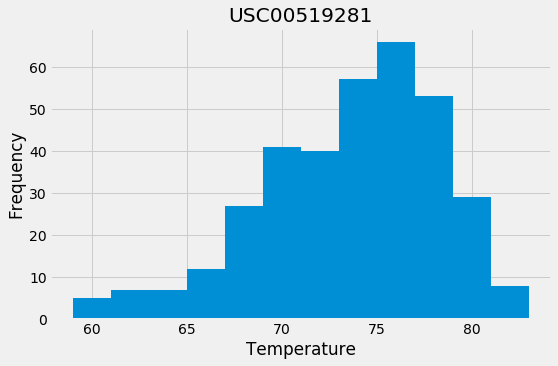

In [260]:
#plot the results as a histogram
plt.hist(highest["tobs"], bins=12)
plt.title("USC00519281")
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.rcParams["figure.figsize"]=[8,5]
plt.savefig("Highest_Temperature.png",bbox_inches = 'tight')

In [267]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [262]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-05-01', '2017-06-10'))

[(65.0, 75.7983193277311, 87.0)]


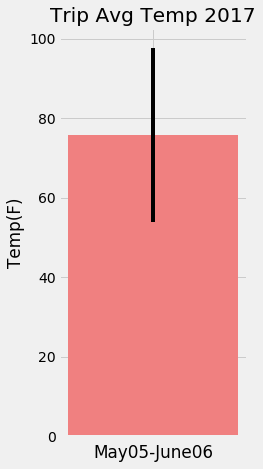

In [263]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
min = 65
avg = 75.80
max = 87
plt.figure(figsize=(3,7))
plt.ylabel("Temp(F)")
plt.xlabel("May05-June06")
plt.title("Trip Avg Temp 2017")
plt.grid
plt.bar(1,avg, yerr = max - min,tick_label="", color='lightcoral')
plt.savefig("Result_trip.png",bbox_inches = 'tight')





In [264]:
# Calculate the total amount of rainfall per weather station for your trip dates using
#the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, 
#name, latitude, longitude, and elevation

sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, \
       Station.elevation, func.sum(Measurement.prcp)]


trip_rainfall = session.query(*sel).filter(Measurement.station == Station.station).\
    filter(Measurement.date >= '2017-05-05').filter(Measurement.date <= '2017-06-06').\
    group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()

trip_rainfall_df = pd.DataFrame(trip_rainfall, columns \
    =['Station Number','Station Name', 'Latitude', 'Longitude', \
      'Elevation', 'Cumulative Rainfall'])
trip_rainfall_df


,Station Number,Station Name,Latitude,Longitude,Elevation,Cumulative Rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,9.75
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,6.14
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,4.42
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,2.76
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2.68
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.77
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


## Optional Challenge Assignment

In [284]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [293]:
# calculate the daily normals for your trip
startDate = "2017-05-01"
endDate = "2017-06-10"

#calculate trip length
startNum = int(startDate[-2:])
endNum = int(endDate[-2:])
tripLength = endNum - startNum + 1

#start date as datetime object
startDate = dt.datetime.strptime(startDate, '%Y-%m-%d')
#list dates (MM-DD) of trip
dateList = [dt.datetime.strftime(startDate + dt.timedelta(days = x), '%m-%d') 
            for x in range(0, tripLength)]

#calculate normals for each date
tripNormals = [daily_normals(date) for date in dateList]

tripNormals

[[(65.0, 72.75925925925925, 79.0)],
 [(65.0, 73.05084745762711, 79.0)],
 [(67.0, 73.41071428571429, 84.0)],
 [(65.0, 73.59649122807018, 78.0)],
 [(67.0, 73.39655172413794, 79.0)],
 [(66.0, 73.14035087719299, 80.0)],
 [(64.0, 71.78846153846153, 79.0)],
 [(65.0, 72.18867924528301, 80.0)],
 [(67.0, 72.9322033898305, 79.0)],
 [(64.0, 73.3157894736842, 78.0)]]

In [294]:

#extract normals into a list of lists
tripNormals = [np.array(normal[0]) for normal in tripNormals]

#convert normals list into a data frame
normalsTable = pd.DataFrame(tripNormals)
#add date column
normalsTable["Date"] = dateList
#set index and rename columns
normalsTable = normalsTable.set_index("Date")
normalsTable = normalsTable.rename(columns={0: "Low Temp", 1: "Avg Temp", 2: "High Temp"})

normalsTable.head()

,Low Temp,Avg Temp,High Temp
Date,,,
05-01,65.0,72.759259,79.0
05-02,65.0,73.050847,79.0
05-03,67.0,73.410714,84.0
05-04,65.0,73.596491,78.0
05-05,67.0,73.396552,79.0


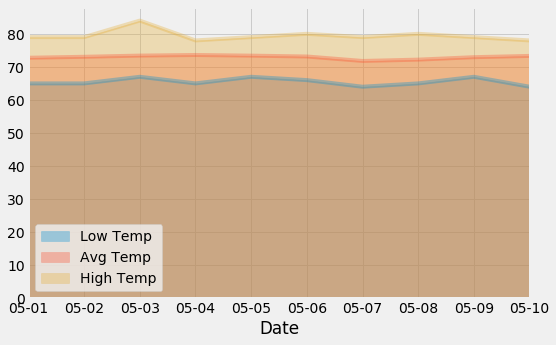

In [295]:
#plot with pandas
normalsTable.plot.area(stacked=False, alpha=.333)

In [273]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
# Plot the daily normals as an area plot with `stacked=False`
